Epoch 1/5
2/2 [==============================] - 2s 434ms/step - loss: 0.0427 - val_loss: 0.0414
Epoch 2/5
2/2 [==============================] - 1s 331ms/step - loss: 0.0413 - val_loss: 0.0409
Epoch 3/5
2/2 [==============================] - 1s 586ms/step - loss: 0.0408 - val_loss: 0.0404
Epoch 4/5
2/2 [==============================] - 1s 583ms/step - loss: 0.0403 - val_loss: 0.0398
Epoch 5/5
2/2 [==============================] - 1s 390ms/step - loss: 0.0398 - val_loss: 0.0392
Epoch 1/5
2/2 [==============================] - 1s 439ms/step - loss: 0.0390 - val_loss: 0.0381
Epoch 2/5
2/2 [==============================] - 1s 320ms/step - loss: 0.0380 - val_loss: 0.0370
Epoch 3/5
2/2 [==============================] - 1s 325ms/step - loss: 0.0368 - val_loss: 0.0356
Epoch 4/5
2/2 [==============================] - 1s 339ms/step - loss: 0.0353 - val_loss: 0.0338
Epoch 5/5
2/2 [==============================] - 1s 326ms/step - loss: 0.0334 - val_loss: 0.0314
Epoch 1/5
2/2 [===============

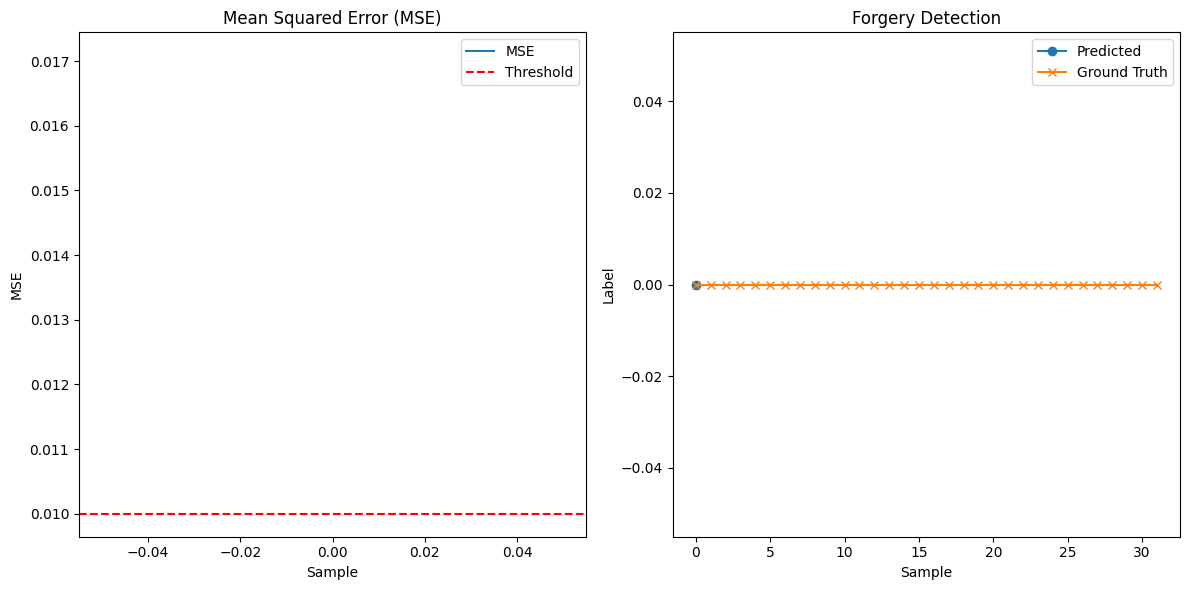

In [197]:
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the autoencoder architecture
input_shape = (64, 64, 1)  # Adjust the input shape according to your video frames
latent_dim = 32

# Define the encoder layers
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# Define the decoder layers
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
outputs = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = tf.keras.Model(inputs, outputs)

# Data preprocessing
def load_data(directory):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.mp4'):
            video_path = os.path.join(directory, filename)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Read frames until the video ends
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Preprocess the frame (e.g., resize, convert to grayscale)
                frame = cv2.resize(frame, (64, 64))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.expand_dims(frame, axis=-1)  # Add channel dimension for grayscale

                # Append the preprocessed frame to the data list
                data.append(frame)
                labels.append(0)  # Assuming fake videos have label 0

            # Release the video capture object
            cap.release()

    return np.array(data), np.array(labels)

# Load the dataset
data_dir = '/content/Video_Forgery'
fake_dir = os.path.join(data_dir, 'fake')
real_dir = os.path.join(data_dir, 'real')

# Select 40 samples from each category
num_samples = 40
x_fake, y_fake = load_data(fake_dir)
x_real, y_real = load_data(real_dir)

x_data = np.concatenate((x_fake[:num_samples], x_real[:num_samples]), axis=0)
y_data = np.concatenate((y_fake[:num_samples], y_real[:num_samples]), axis=0)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=42)

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to match the input shape of the autoencoder model
x_train = np.reshape(x_train, (-1, 64, 64, 1))
x_test = np.reshape(x_test, (-1, 64, 64, 1))

# Convert NumPy arrays to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)

# Train the model for 3 iterations
num_iterations = 3

for i in range(num_iterations):
    # Compile and train the model
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train_tf, x_train_tf, epochs=5, batch_size=32, validation_data=(x_test_tf, x_test_tf))

# Use the trained autoencoder for video forgery detection
decoded_videos = autoencoder.predict(x_fake)

# Calculate the mean squared error (MSE) between the original and decoded videos
decoded_videos = autoencoder.predict(x_test)
mse = np.mean((x_test - decoded_videos) ** 2)

threshold = 0.01  # Define a threshold for detecting forgery

# Compare MSE with the threshold to detect forgery
if mse > threshold:
    print("Forgery detected!")
else:
    print("No forgery detected.")

# Perform evaluation
y_pred = (mse < threshold).astype(int)

# Calculate loss using evaluate() method
loss = autoencoder.evaluate(x_test_tf, x_test_tf)

# Print evaluation metrics
accuracy = np.mean(y_pred == y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Loss: {:.4f}".format(loss))

# Plotting the evaluation graphs
plt.figure(figsize=(12, 6))

# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(mse)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Sample')
plt.ylabel('MSE')
plt.legend(['MSE', 'Threshold'])

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(y_pred, 'o-', label='Predicted')
plt.plot(y_test, 'x-', label='Ground Truth')
plt.title('Forgery Detection')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['Predicted', 'Ground Truth'])

plt.tight_layout()
plt.show()
